In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [3]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data["t_average_training_score_in_department"] = data.apply(lambda x: (np.mean(x["department_average_training_scores"]) - x["avg_training_score"])/(np.std(x["department_average_training_scores"])/np.sqrt(len(x["department_average_training_scores"]))), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [4]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [5]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [6]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 70, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903472	valid_1's auc: 0.920492
[200]	training's auc: 0.910824	valid_1's auc: 0.920471
[300]	training's auc: 0.913352	valid_1's auc: 0.919919
Early stopping, best iteration is:
[139]	training's auc: 0.906543	valid_1's auc: 0.923718
Fold 0 best Split 0.46 and best Score 0.618556701031


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903125	valid_1's auc: 0.891942
[200]	training's auc: 0.910618	valid_1's auc: 0.90438
[300]	training's auc: 0.913187	valid_1's auc: 0.906357
[400]	training's auc: 0.9156	valid_1's auc: 0.906576
[500]	training's auc: 0.917374	valid_1's auc: 0.906451
Early stopping, best iteration is:
[333]	training's auc: 0.914226	valid_1's auc: 0.907908
Fold 1 best Split 0.19 and best Score 0.522388059701
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903799	valid_1's auc: 0.893659
[200]	training's auc: 0.910682	valid_1's auc: 0.8975
[300]	training's auc: 0.9133	valid_1's auc: 0.900914
[400]	training's auc: 0.915728	valid_1's auc: 0.90413
[500]	training's auc: 0.917423	valid_1's auc: 0.905587
[600]	training's auc: 0.919019	valid_1's auc: 0.906628
[700]	training's auc: 0.920417	valid_1's auc: 0.907846
[800]	training's auc: 0.921584	valid_1's auc: 0.906638
[900]	training's auc: 0.

[700]	training's auc: 0.920462	valid_1's auc: 0.897521
[800]	training's auc: 0.921516	valid_1's auc: 0.897333
Early stopping, best iteration is:
[658]	training's auc: 0.920017	valid_1's auc: 0.897895
Fold 12 best Split 0.33 and best Score 0.520833333333
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902986	valid_1's auc: 0.918139
[200]	training's auc: 0.910261	valid_1's auc: 0.919774
[300]	training's auc: 0.913243	valid_1's auc: 0.922625
[400]	training's auc: 0.915489	valid_1's auc: 0.924332
[500]	training's auc: 0.917472	valid_1's auc: 0.923666
Early stopping, best iteration is:
[366]	training's auc: 0.914954	valid_1's auc: 0.924894
Fold 13 best Split 0.25 and best Score 0.549019607843
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90336	valid_1's auc: 0.915256
[200]	training's auc: 0.910287	valid_1's auc: 0.916651
[300]	training's auc: 0.913164	valid_1's auc: 0.91841
[400]	training's auc: 0.915278	valid_1

[500]	training's auc: 0.917658	valid_1's auc: 0.899441
[600]	training's auc: 0.919185	valid_1's auc: 0.900338
[700]	training's auc: 0.920365	valid_1's auc: 0.901255
[800]	training's auc: 0.921623	valid_1's auc: 0.900671
[900]	training's auc: 0.922482	valid_1's auc: 0.901151
[1000]	training's auc: 0.923328	valid_1's auc: 0.900859
Early stopping, best iteration is:
[847]	training's auc: 0.921998	valid_1's auc: 0.901713
Fold 26 best Split 0.22 and best Score 0.475409836066
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903366	valid_1's auc: 0.913189
[200]	training's auc: 0.910843	valid_1's auc: 0.910302
Early stopping, best iteration is:
[68]	training's auc: 0.899078	valid_1's auc: 0.914565
Fold 27 best Split 0.28 and best Score 0.552380952381
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903894	valid_1's auc: 0.89818
[200]	training's auc: 0.910976	valid_1's auc: 0.901755
[300]	training's auc: 0.913431	valid_

[500]	training's auc: 0.918065	valid_1's auc: 0.875761
[600]	training's auc: 0.919568	valid_1's auc: 0.877408
[700]	training's auc: 0.9209	valid_1's auc: 0.877845
[800]	training's auc: 0.921918	valid_1's auc: 0.87943
[900]	training's auc: 0.922885	valid_1's auc: 0.879826
[1000]	training's auc: 0.923856	valid_1's auc: 0.880847
[1100]	training's auc: 0.924672	valid_1's auc: 0.880368
[1200]	training's auc: 0.925489	valid_1's auc: 0.880576
Early stopping, best iteration is:
[1006]	training's auc: 0.923915	valid_1's auc: 0.880931
Fold 39 best Split 0.47 and best Score 0.47191011236
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.904126	valid_1's auc: 0.886059
[200]	training's auc: 0.910629	valid_1's auc: 0.892969
[300]	training's auc: 0.91338	valid_1's auc: 0.891791
[400]	training's auc: 0.916139	valid_1's auc: 0.897107
[500]	training's auc: 0.917715	valid_1's auc: 0.90163
[600]	training's auc: 0.919241	valid_1's auc: 0.90286
[700]	training's auc: 0.92

[400]	training's auc: 0.915677	valid_1's auc: 0.911419
[500]	training's auc: 0.917636	valid_1's auc: 0.915651
[600]	training's auc: 0.918964	valid_1's auc: 0.917513
[700]	training's auc: 0.920254	valid_1's auc: 0.918889
[800]	training's auc: 0.921269	valid_1's auc: 0.91946
[900]	training's auc: 0.922284	valid_1's auc: 0.920179
[1000]	training's auc: 0.923159	valid_1's auc: 0.920412
[1100]	training's auc: 0.923974	valid_1's auc: 0.920455
[1200]	training's auc: 0.924639	valid_1's auc: 0.92056
[1300]	training's auc: 0.925344	valid_1's auc: 0.920751
[1400]	training's auc: 0.926062	valid_1's auc: 0.920582
[1500]	training's auc: 0.926714	valid_1's auc: 0.920941
[1600]	training's auc: 0.927352	valid_1's auc: 0.921407
[1700]	training's auc: 0.927989	valid_1's auc: 0.921555
[1800]	training's auc: 0.928494	valid_1's auc: 0.921386
[1900]	training's auc: 0.929034	valid_1's auc: 0.921936
[2000]	training's auc: 0.929553	valid_1's auc: 0.921957
[2100]	training's auc: 0.930106	valid_1's auc: 0.922486


[800]	training's auc: 0.921587	valid_1's auc: 0.908139
Early stopping, best iteration is:
[664]	training's auc: 0.920075	valid_1's auc: 0.908858
Fold 64 best Split 0.27 and best Score 0.5625
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.904261	valid_1's auc: 0.865403
[200]	training's auc: 0.911081	valid_1's auc: 0.865742
[300]	training's auc: 0.913801	valid_1's auc: 0.871561
[400]	training's auc: 0.91623	valid_1's auc: 0.875423
[500]	training's auc: 0.918016	valid_1's auc: 0.876524
[600]	training's auc: 0.919736	valid_1's auc: 0.877391
[700]	training's auc: 0.921099	valid_1's auc: 0.877709
[800]	training's auc: 0.922174	valid_1's auc: 0.877645
[900]	training's auc: 0.923217	valid_1's auc: 0.877031
[1000]	training's auc: 0.92409	valid_1's auc: 0.877603
Early stopping, best iteration is:
[821]	training's auc: 0.922384	valid_1's auc: 0.878068
Fold 65 best Split 0.28 and best Score 0.458333333333
Training until validation scores don't improve for 20

In [7]:
test_id.to_csv("csv/prediction6.csv", index = False)

In [8]:
test_id["is_promoted"].mean()

0.04942528735632184

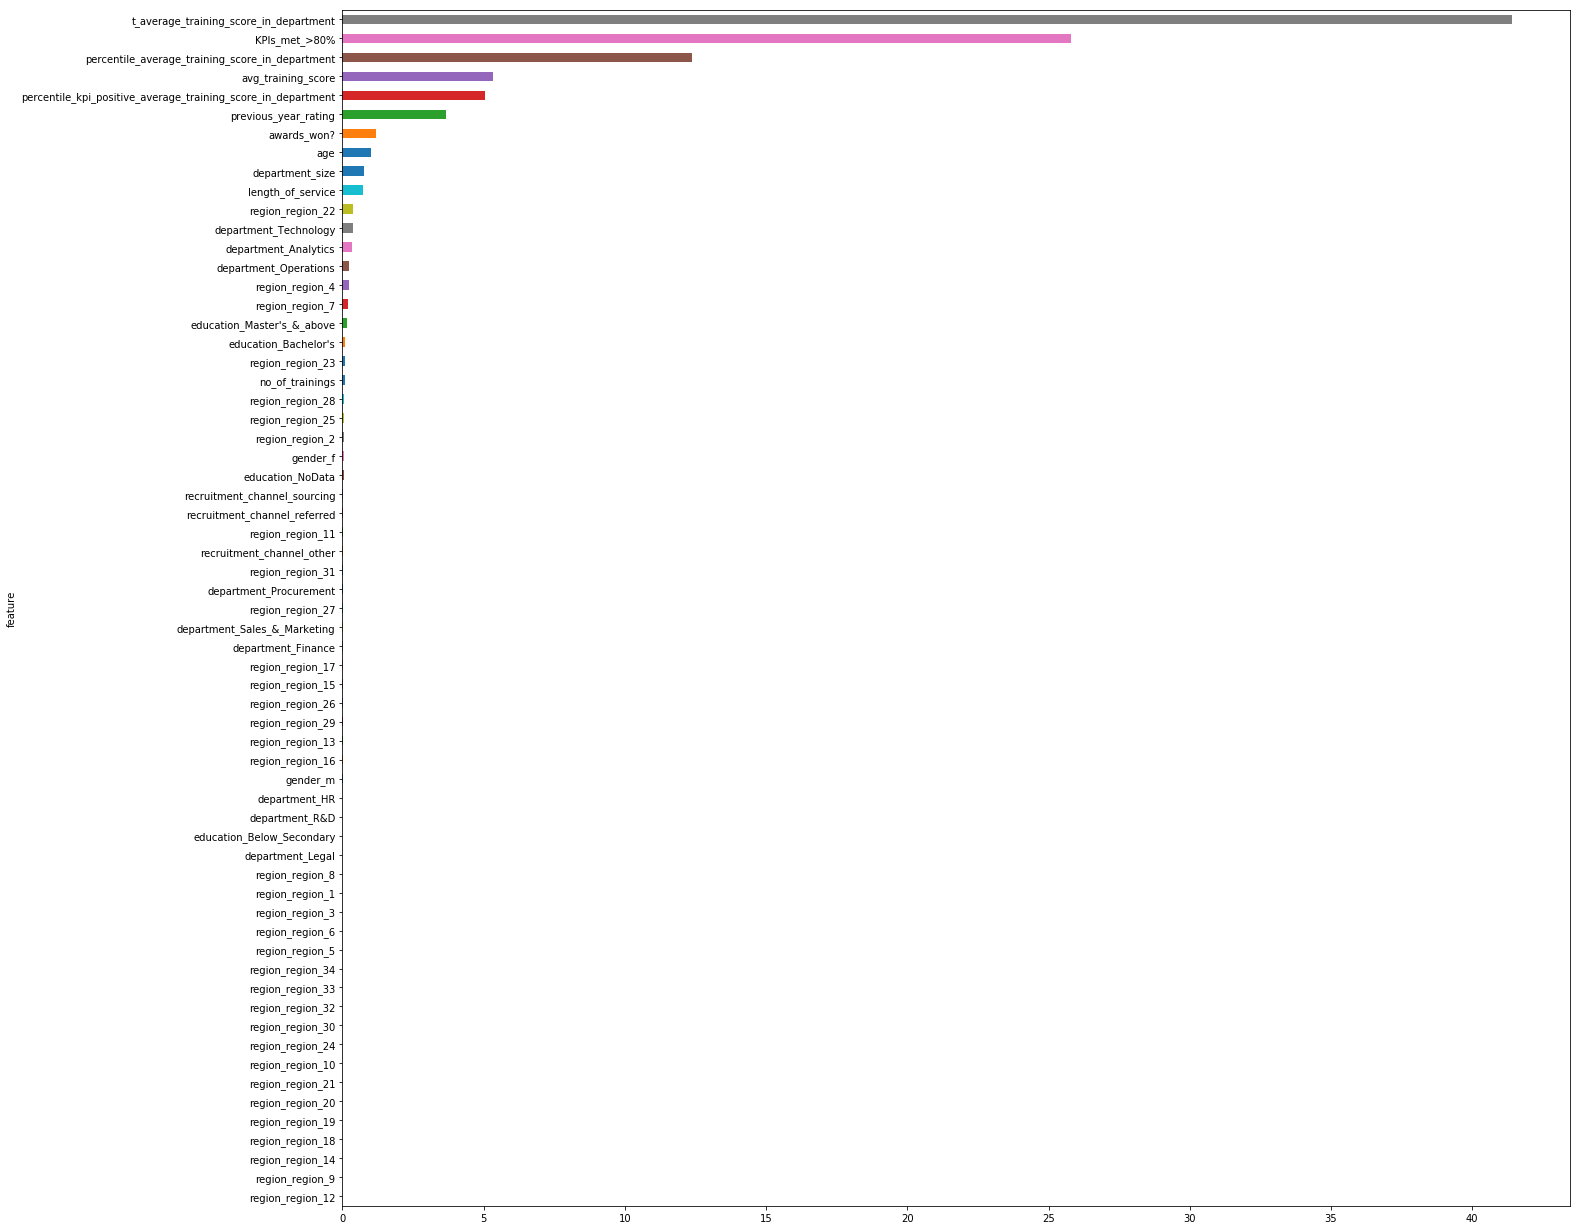

In [9]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))